In [1]:
from opt_einsum.paths import branch_1
!apt-get update
!apt-get install graphviz -y

!pip install tensorflow==2.13.0
!pip install numpy
!pip install pandas
!pip install keras==2.13.1
!pip install scikit-learn
!pip install matplotlib
!pip install joblib
!pip install pyarrow
!pip install fastparquet
!pip install scipy
!pip install seaborn
!pip install tqdm
!pip install pydot
!pip install tensorflow-io
!pip install tensorflow-addons

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 121 not upgraded.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is av

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, MultiHeadAttention, Dropout, BatchNormalization, LayerNormalization, Input, Activation, Lambda, Bidirectional, Add, MaxPooling1D, Conv1D, GlobalAveragePooling1D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
import json
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa
import os
import joblib


folder_name = datetime.now().strftime("%Y-%m-%d_%H-%M")
random_state_value = None

2024-11-20 11:04:20.516922: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
def get_season(date):
    month = date.month
    day = date.day
    if (month == 12 and day >= 21) or (month <= 3 and day < 20):
        return 'Winter'
    elif (month == 3 and day >= 20) or (month <= 6 and day < 21):
        return 'Spring'
    elif (month == 6 and day >= 21) or (month <= 9 and day < 23):
        return 'Summer'
    elif (month == 9 and day >= 23) or (month <= 12 and day < 21):
        return 'Autumn'
    else:
        return 'Unknown'


def get_time_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'


def add_time_features(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['timestamp'] = df['datetime'].astype(np.int64) // 10 ** 9
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['hour_sin'] = np.sin(df['hour'] * (2 * np.pi / 24))
    df['hour_cos'] = np.cos(df['hour'] * (2 * np.pi / 24))
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['week_of_year'] = df['datetime'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['datetime'].dt.quarter
    df['is_month_end'] = df['datetime'].dt.is_month_end.astype(int)
    df['is_quarter_end'] = df['datetime'].dt.is_quarter_end.astype(int)
    df['is_year_end'] = df['datetime'].dt.is_year_end.astype(int)
    df['month_sin'] = np.sin(df['month'] * (2 * np.pi / 12))
    df['month_cos'] = np.cos(df['month'] * (2 * np.pi / 12))
    df['day_of_year_sin'] = np.sin(df['day_of_year'] * (2 * np.pi / 365.25))
    df['day_of_year_cos'] = np.cos(df['day_of_year'] * (2 * np.pi / 365.25))
    df['season'] = df['datetime'].apply(get_season)
    df['time_period'] = df['hour'].apply(get_time_period)
    return df


def add_solar_features(df):
    # Calculate solar angle
    df['solar_angle'] = np.sin(df['day_of_year'] * (2 * np.pi / 365.25)) * np.sin(df['hour'] * (2 * np.pi / 24))

    # Interactions between relevant features
    df['cloud_temp_interaction'] = df['cloudcover'] * df['temp']
    df['visibility_cloud_interaction'] = df['visibility'] * (100 - df['cloudcover'])

    # Derived features
    df['clear_sky_index'] = (100 - df['cloudcover']) / 100
    df['temp_gradient'] = df['temp'] - df['tempmin']

    return df


def add_solar_specific_features(df):
    # Solar angle and day length calculations
    df['day_length'] = 12 + 3 * np.sin(2 * np.pi * (df['day_of_year'] - 81) / 365.25)
    df['solar_noon'] = 12 - df['hour']
    df['solar_elevation'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25) * np.cos(2 * np.pi * df['solar_noon'] / 24)

    # Feature interactions
    df['cloud_elevation'] = df['cloudcover'] * df['solar_elevation']
    df['visibility_elevation'] = df['visibility'] * df['solar_elevation']

    # Extended window rolling features
    df['cloud_rolling_12h'] = df['cloudcover'].rolling(window=12).mean()
    df['temp_rolling_12h'] = df['temp'].rolling(window=12).mean()

    return df


def add_uv_specific_features(df):
    # Solar zenith angle calculation
    lat = 41.9  # assuming constant latitude for the dataset - Rome's latitude
    df['solar_zenith'] = 90 - np.degrees(
        np.arcsin(
            np.sin(np.radians(lat)) * np.sin(df['solar_elevation']) +
            np.cos(np.radians(lat)) * np.cos(df['solar_elevation']) * np.cos(df['hour'] * 15)
        )
    )

    # UV peak hours indicator (10:00-16:00)
    df['is_uv_peak_hours'] = ((df['hour'] >= 10) & (df['hour'] <= 16)).astype(int)

    # Atmospheric attenuation factor
    df['atmospheric_attenuation'] = (100 - df['cloudcover']) * (df['visibility'] / 100) * (1 - df['humidity'] / 200)

    # Seasonal UV factor
    df['uv_seasonal_factor'] = np.where(df['season_Summer'], 1.0,
                                        np.where(df['season_Spring'], 0.7,
                                                 np.where(df['season_Autumn'], 0.5, 0.3)))

    # Solar elevation and atmospheric transparency interaction
    df['solar_clarity_index'] = df['solar_elevation'] * df['atmospheric_attenuation'] / 100

    # UV-specific rolling features
    df['clarity_rolling_3h'] = df['atmospheric_attenuation'].rolling(window=3).mean()
    df['temp_uv_interaction'] = df['temp'] * df['solar_clarity_index']

    return df


def add_advanced_features(df):
    """
    Add all advanced features in the correct order
    """
    # 1. First add basic time features
    df = add_time_features(df)

    # 2. One-hot encoding for categorical features
    df = pd.get_dummies(df, columns=['season', 'time_period'])
    
    # 3. Add solar and specific features
    df = add_solar_features(df)
    df = add_solar_specific_features(df)
    
    # 4. Ensure datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # 5. Add weather variable interactions
    df['temp_humidity'] = df['temp'] * df['humidity']
    df['temp_cloudcover'] = df['temp'] * df['cloudcover']
    df['visibility_cloudcover'] = df['visibility'] * df['cloudcover']

    # 6. Add solar radiation derived features
    df['clear_sky_factor'] = (100 - df['cloudcover']) / 100
    df['day_length'] = np.sin(df['day_of_year_sin']) * 12 + 12

    # 7. Add lag features
    df['temp_1h_lag'] = df['temp'].shift(1)
    df['cloudcover_1h_lag'] = df['cloudcover'].shift(1)
    df['humidity_1h_lag'] = df['humidity'].shift(1)

    # 8. Add rolling means
    df['temp_rolling_mean_6h'] = df['temp'].rolling(window=6).mean()
    df['cloudcover_rolling_mean_6h'] = df['cloudcover'].rolling(window=6).mean()
    df['temp_humidity_interaction'] = df['temp'] * df['humidity'] / 100

    # 9. Add atmospheric stability
    df['atmospheric_stability'] = df.groupby(df.index.date)['pressure'].transform(
        lambda x: x.std()
    ).fillna(0)

    # 10. Add extreme conditions indicator
    df['extreme_conditions'] = ((df['temp'] > df['temp'].quantile(0.75)) &
                               (df['humidity'] < df['humidity'].quantile(0.25))).astype(int)

    # 11. Add atmospheric transparency
    df['atmospheric_transparency'] = (100 - df['cloudcover']) * (df['visibility'] / 10)

    # 12. Add transitional seasons indicator
    df['is_transition_season'] = ((df['season_Spring'] | df['season_Autumn'])).astype(int)

    # 13. Add solar cloud effect
    if 'solar_elevation' in df.columns:
        df['solar_cloud_effect'] = df['solar_elevation'] * (100 - df['cloudcover']) / 100

    # 14. Finally add UV specific features
    df = add_uv_specific_features(df)

    return df


def prepare_advanced_data(df):
    """
    Prepares data for UV index prediction model with advanced feature engineering
    and optimized preprocessing.

    Args:
        df: DataFrame with meteorological data

    Returns:
        tuple: (X_train_scaled, X_test_scaled, y_train, y_test, scaler, final_features, X_to_predict_scaled)
    """
    # Apply feature engineering functions
    df = add_advanced_features(df)

    # Optimized feature selection for UV index
    selected_features = {
        # Primary meteorological features
        'atmospheric': [
            'temp', 'humidity', 'cloudcover', 'visibility',
            'clear_sky_index', 'atmospheric_transparency'
        ],
    
        # Essential temporal features
        'temporal': [
            'hour_sin', 'hour_cos',
            'day_of_year_sin', 'day_of_year_cos'
        ],
    
        # Solar features
        'solar': [
            'solar_angle', 'solar_elevation',
            'day_length', 'solar_noon',
            'solar_cloud_effect'
        ],
    
        # Key interactions
        'interactions': [
            'cloud_temp_interaction',
            'visibility_cloud_interaction',
            'temp_humidity_interaction',
            'solar_clarity_index'
        ],
    
        # Rolling features
        'rolling': [
            'cloud_rolling_12h',
            'temp_rolling_mean_6h'
        ]
    }

    # Flatten feature list
    base_features = [item for sublist in selected_features.values() for item in sublist]

    # Add categorical features (one-hot encoded)
    categorical_columns = [col for col in df.columns if col.startswith(('season_', 'time_period_'))]
    final_features = base_features + categorical_columns

    # Temporal preprocessing
    df = df.sort_values('datetime')
    df.set_index('datetime', inplace=True)

    # Advanced interpolation for missing values
    for column in final_features:
        if column in df.columns:
            if df[column].isnull().any():
                if column in selected_features['rolling']:
                    df[column] = df[column].ffill().bfill()
                else:
                    df[column] = df[column].interpolate(method='time', limit_direction='both')

    # Temporal data split
    data_after_2010 = df[df.index.year >= 2010].copy()
    data_before_2010 = df[df.index.year < 2010].copy()

    print(f"\nTemporal distribution of data:")
    print(f"Records after 2010: {len(data_after_2010):,}")
    print(f"Records before 2010: {len(data_before_2010):,}")

    # Feature and target preparation
    X = data_after_2010[final_features]
    y = data_after_2010['uvindex']
    X_to_predict = data_before_2010[final_features]

    # Data validation
    if X.isnull().any().any() or y.isnull().any():
        print("\nWarning: Found missing values after preprocessing")
        print("Features with missing values:", X.columns[X.isnull().any()].tolist())
        X = X.fillna(X.mean())
        y = y.fillna(y.mean())

    # Stratified data split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.5,
        random_state=random_state_value,
        stratify=pd.qcut(y, q=5, duplicates='drop', labels=False)
    )

    # Robust feature scaling
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_to_predict_scaled = scaler.transform(X_to_predict)

    # Final validation
    assert not np.isnan(X_train_scaled).any(), "Found NaN in X_train_scaled"
    assert not np.isnan(X_test_scaled).any(), "Found NaN in X_test_scaled"
    assert not np.isnan(X_to_predict_scaled).any(), "Found NaN in X_to_predict_scaled"

    # Print feature information
    print("\nNumber of features used:", len(final_features))
    print("\nFeature categories:")
    for category, features in selected_features.items():
        print(f"{category}: {len(features)} features")
    print(f"Categorical: {len(categorical_columns)} features")

    return (X_train_scaled, X_test_scaled, y_train, y_test,
            scaler, final_features, X_to_predict_scaled)


def create_sequence_data(X, sequence_length=24):
    """
    Converts data into sequences for LSTM input
    sequence_length represents how many previous hours to consider
    """
    sequences = []
    for i in range(len(X) - sequence_length + 1):
        sequences.append(X[i:i + sequence_length])
    return np.array(sequences)


def prepare_hybrid_data(df):
    # Use existing data preparation
    X_train_scaled, X_test_scaled, y_train, y_test, scaler, features, X_to_predict_scaled = prepare_advanced_data(df)

    # Convert data to sequences
    sequence_length = 24  # 24 hours of historical data

    X_train_seq = create_sequence_data(X_train_scaled, sequence_length)
    X_test_seq = create_sequence_data(X_test_scaled, sequence_length)

    # Adjust y by removing the first (sequence_length-1) elements
    y_train = y_train[sequence_length - 1:]
    y_test = y_test[sequence_length - 1:]

    X_to_predict_seq = create_sequence_data(X_to_predict_scaled, sequence_length)

    return X_train_seq, X_test_seq, y_train, y_test, scaler, features, X_to_predict_seq

In [10]:
def create_residual_lstm_layer(x, units, dropout_rate, l2_reg=0.01,
                               survival_probability=0.8, return_sequences=True):
    """LSTM layer with stochastic depth"""
    residual = x
    
    # Main path
    x = Bidirectional(LSTM(units, return_sequences=return_sequences,
                           kernel_regularizer=regularizers.l2(l2_reg)))(x)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Adjust residual dimension if needed
    if return_sequences:
        # For Bidirectional LSTM, the output dimension is 2 * units
        target_dim = 2 * units
        if int(residual.shape[-1]) != target_dim:
            # Use Dense layer instead of Conv1D for better dimension matching
            residual = Dense(target_dim)(residual)
        
    # Apply stochastic depth only if dimensions match
    if x.shape[-1] == residual.shape[-1]:
        x = tfa.layers.StochasticDepth(survival_probability)([x, residual])
    else:
        print(f"Warning: Dimension mismatch - x: {x.shape}, residual: {residual.shape}")
        # Skip residual connection if dimensions don't match
        pass

    return x


def attention_block(x, units, num_heads=8, survival_probability=0.8):
    """
    Attention block with stochastic depth.
    """
    original_x = x
    
    # Compute self-attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=units)(x, x)
    
    # Ensure dimensions match before applying stochastic depth
    if attention.shape[-1] != original_x.shape[-1]:
        original_x = Dense(attention.shape[-1])(original_x)
    
    # Apply stochastic depth to the attention path
    x = tfa.layers.StochasticDepth(survival_probability)([attention, original_x])
    x = LayerNormalization()(x)

    # Store the input to the FFN
    ffn_input = x
    
    # FFN block
    x = Dense(units * 4, activation='swish')(x)
    x = Dense(ffn_input.shape[-1])(x)  # Match the input dimension
    
    # Apply stochastic depth to the FFN
    x = tfa.layers.StochasticDepth(survival_probability)([x, ffn_input])
    x = LayerNormalization()(x)

    return x


def create_uv_index_model(input_shape, folder_name, l2_lambda=0.005):
    inputs = Input(shape=input_shape)

    # Further adjusted hyperparameters
    survival_probs = [0.98, 0.95, 0.92]  # Even higher survival probabilities
    attention_survival_probs = [0.95, 0.92, 0.9]

    # First LSTM block
    x = create_residual_lstm_layer(
        inputs, 64, dropout_rate=0.2,  # Further reduced dropout
        l2_reg=l2_lambda,
        survival_probability=survival_probs[0],
        return_sequences=True
    )
    x = attention_block(x, 128, num_heads=2,  # Reduced heads
                        survival_probability=attention_survival_probs[0])

    # Second LSTM block
    x = create_residual_lstm_layer(
        x, 32, dropout_rate=0.15,
        l2_reg=l2_lambda,
        survival_probability=survival_probs[1],
        return_sequences=True
    )
    x = attention_block(x, 64, num_heads=2,
                        survival_probability=attention_survival_probs[1])

    # Third LSTM block
    x = create_residual_lstm_layer(
        x, 16, dropout_rate=0.1,
        l2_reg=l2_lambda,
        survival_probability=survival_probs[2],
        return_sequences=True
    )
    x = attention_block(x, 32, num_heads=2,
                        survival_probability=attention_survival_probs[2])

    # Global attention with reduced complexity
    x_input = x
    x = MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    
    if x.shape[-1] != x_input.shape[-1]:
        x_input = Dense(x.shape[-1])(x_input)
    
    x = tfa.layers.StochasticDepth(survival_probability=0.95)([x, x_input])
    x = LayerNormalization()(x)

    # Simplified dense layers
    x = GlobalAveragePooling1D()(x)
    
    # Gradual dimension reduction
    x = Dense(32, activation='swish', kernel_regularizer=regularizers.l2(l2_lambda/2), kernel_constraint=tf.keras.constraints.MaxNorm(3))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.05)(x)  # Minimal dropout

    x = Dense(16, activation='swish',
              kernel_regularizer=regularizers.l2(l2_lambda/2))(x)
    x = BatchNormalization()(x)

    # Modified output layer
    x = Dense(8, activation='swish')(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Sigmoid activation
    outputs = Lambda(lambda x: x * 11.0)(outputs)  # Scale to [0, 11] range

    model = Model(inputs=inputs, outputs=outputs, name="UvModel")

    # More stable learning rate schedule
    initial_learning_rate = 0.0001  # Further reduced
    warmup_steps = 1000
    decay_steps = 5000

    # Corretto learning rate schedule
    class CustomLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
        def __init__(self, initial_lr=0.0001, warmup_steps=1000, decay_steps=5000):
            super().__init__()
            self.initial_lr = initial_lr
            self.warmup_steps = warmup_steps
            self.decay_steps = decay_steps

        def __call__(self, step):
            # Convert to float32
            step_f = tf.cast(step, tf.float32)
            warmup_steps_f = tf.cast(self.warmup_steps, tf.float32)
            decay_steps_f = tf.cast(self.decay_steps, tf.float32)

            # Warmup phase
            warmup_progress = step_f / warmup_steps_f
            warmup_lr = self.initial_lr * warmup_progress

            # Decay phase
            decay_progress = (step_f - warmup_steps_f) / decay_steps_f
            decay_factor = 0.5 * (1.0 + tf.cos(tf.constant(np.pi) * decay_progress))
            decay_lr = self.initial_lr * decay_factor

            # Combine phases
            lr = tf.where(step_f < warmup_steps_f, warmup_lr, decay_lr)
            return lr

        def get_config(self):
            return {
                "initial_lr": self.initial_lr,
                "warmup_steps": self.warmup_steps,
                "decay_steps": self.decay_steps
            }

    # Utilizzo dello schedule corretto
    lr_schedule = CustomLRSchedule(
        initial_lr=0.0001,
        warmup_steps=1000,
        decay_steps=5000
    )

    optimizer = AdamW(
        learning_rate=lr_schedule,
        weight_decay=0.0005,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )

    # Improved loss function
    def smooth_uv_loss(y_true, y_pred):
        # Basic MSE with smoothing
        mse = tf.square(y_true - y_pred)
        
        # Smooth L1 component for better stability
        abs_diff = tf.abs(y_true - y_pred)
        smooth_l1 = tf.where(abs_diff < 1.0,
                            0.5 * tf.square(abs_diff),
                            abs_diff - 0.5)
        
        # Combined loss with dynamic weighting
        combined_loss = 0.7 * mse + 0.3 * smooth_l1
        
        # Gentle weighting for high UV values
        high_uv_weight = tf.where(y_true >= 8.0, 1.2, 1.0)
        
        # Smooth peak hours weight
        time_of_day = tf.cast(tf.math.floormod(tf.range(tf.shape(y_true)[0]), 24),
                              tf.float32)
        peak_weight = 1.0 + 0.2 * tf.math.sigmoid((time_of_day - 10.0) * 0.5) * \
                           tf.math.sigmoid((16.0 - time_of_day) * 0.5)
        
        total_weight = high_uv_weight * peak_weight
        
        return tf.reduce_mean(combined_loss * total_weight)

    # Improved MAPE metric
    def smooth_mape(y_true, y_pred):
        epsilon = 1e-7
        diff = tf.abs(y_true - y_pred)
        scale = tf.maximum(tf.abs(y_true) + epsilon, 0.5)  # Minimum scale of 0.5
        return tf.reduce_mean(diff / scale) * 100

    model.compile(
        optimizer=optimizer,
        loss=smooth_uv_loss,
        metrics=[
            'mae',
            'mse',
            tf.keras.metrics.RootMeanSquaredError(),
            smooth_mape
        ]
    )

    model.summary()

    # Save model architecture visualization
    plot_model(model,
               to_file=f'{folder_name}_model_architecture.png',
               show_shapes=True,
               show_layer_names=True,
               dpi=150,
               show_layer_activations=True)

    return model


def evaluate_uv_predictions(y_true, y_pred, folder_name=None):
    """
    Comprehensive evaluation of UV index predictions with detailed analysis and visualizations.

    Parameters:
    -----------
    y_true : array-like
        Actual UV index values
    y_pred : array-like
        Predicted UV index values
    folder_name : str, optional
        Folder to save analysis plots

    Returns:
    --------
    dict
        Dictionary containing all calculated metrics
    """
    import os
    from datetime import datetime
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, r2_score

    # Initialize plot paths
    main_plot_path = None
    conf_matrix_path = None

    # Data preprocessing
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()

    # Rounding and clipping predictions
    y_pred_rounded = np.round(y_pred * 2) / 2  # Round to nearest 0.5
    y_pred_clipped = np.clip(y_pred_rounded, 0, 11)

    # Calculate errors
    errors = y_pred - y_true
    errors_rounded = y_pred_clipped - y_true

    # Function to determine UV risk level
    def get_uv_risk_level(values):
        levels = np.full_like(values, 'Low', dtype=object)
        levels[(values > 2) & (values <= 5)] = 'Moderate'
        levels[(values > 5) & (values <= 7)] = 'High'
        levels[(values > 7) & (values <= 10)] = 'Very High'
        levels[values > 10] = 'Extreme'
        return levels

    # Calculate basic metrics
    metrics = {
        'raw': {
            'mae': mean_absolute_error(y_true, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
            'r2': r2_score(y_true, y_pred),
            'mean_error': np.mean(errors),
            'std_error': np.std(errors),
            'median_error': np.median(errors),
            'p95_abs_error': np.percentile(np.abs(errors), 95)
        },
        'rounded': {
            'mae': mean_absolute_error(y_true, y_pred_clipped),
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred_clipped)),
            'r2': r2_score(y_true, y_pred_clipped)
        }
    }

    # Calculate accuracies for different margins
    for data_type, errors_data in [('raw', errors), ('rounded', errors_rounded)]:
        metrics[data_type].update({
            'within_05': np.mean(np.abs(errors_data) <= 0.5) * 100,
            'within_1': np.mean(np.abs(errors_data) <= 1.0) * 100,
            'within_15': np.mean(np.abs(errors_data) <= 1.5) * 100,
            'within_2': np.mean(np.abs(errors_data) <= 2.0) * 100
        })

    # Analysis by UV risk level
    y_true_risk = get_uv_risk_level(y_true)
    y_pred_risk = get_uv_risk_level(y_pred_clipped)

    # Calculate confusion matrix with handling for missing classes
    risk_levels = ['Low', 'Moderate', 'High', 'Very High', 'Extreme']
    
    # Get unique labels present in the data
    present_labels = np.unique(np.concatenate([y_true_risk, y_pred_risk]))
    
    # Calculate confusion matrix for present labels
    cm = confusion_matrix(y_true_risk, y_pred_risk, labels=present_labels)
    
    # Create full confusion matrix with zeros
    full_cm = np.zeros((len(risk_levels), len(risk_levels)))
    
    # Map present labels to their positions in the full matrix
    label_positions = {label: i for i, label in enumerate(risk_levels)}
    for i, true_label in enumerate(present_labels):
        for j, pred_label in enumerate(present_labels):
            full_cm[label_positions[true_label], label_positions[pred_label]] = cm[i, j]
    
    # Create DataFrame with all risk levels
    cm_df = pd.DataFrame(full_cm, columns=risk_levels, index=risk_levels)

    # Analysis by UV range
    uv_ranges = [
        (0, 2, 'Low'),
        (2, 5, 'Moderate'),
        (5, 7, 'High'),
        (7, 10, 'Very High'),
        (10, 11, 'Extreme')
    ]

    range_analysis = {}
    for low, high, label in uv_ranges:
        mask = (y_true >= low) & (y_true < high)
        if mask.any():
            range_analysis[label] = {
                'mae': mean_absolute_error(y_true[mask], y_pred[mask]),
                'count': np.sum(mask),
                'accuracy_within_05': np.mean(np.abs(errors[mask]) <= 0.5) * 100,
                'accuracy_within_1': np.mean(np.abs(errors[mask]) <= 1.0) * 100
            }

    # Visualizations
    if folder_name is not None:
        try:
            # Main figure with 4 subplots
            fig = plt.figure(figsize=(20, 15))

            # 1. Error distribution
            plt.subplot(2, 2, 1)
            plt.hist(errors, bins=50, alpha=0.7)
            plt.title('Prediction Error Distribution')
            plt.xlabel('Error')
            plt.ylabel('Frequency')

            # 2. Actual vs Predicted scatter plot
            plt.subplot(2, 2, 2)
            plt.scatter(y_true, y_pred, alpha=0.5)
            plt.plot([0, 11], [0, 11], 'r--', lw=2)
            plt.title('Actual vs Predicted Values')
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')

            # 3. Errors vs Actual Values
            plt.subplot(2, 2, 3)
            plt.scatter(y_true, errors, alpha=0.5)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.title('Errors vs Actual Values')
            plt.xlabel('Actual Values')
            plt.ylabel('Error')

            # 4. Accuracy and MAE by range
            ax = plt.subplot(2, 2, 4)
            x_labels = [f"{label}\n({low}-{high})" for low, high, label in uv_ranges]
            accuracies = [range_analysis[label]['accuracy_within_05']
                          for _, _, label in uv_ranges if label in range_analysis]
            mae_values = [range_analysis[label]['mae']
                          for _, _, label in uv_ranges if label in range_analysis]

            bars = plt.bar(x_labels, accuracies, alpha=0.6)
            plt.ylabel('Accuracy within ±0.5 (%)')
            plt.title('Accuracy and MAE by UV Range')

            # Add MAE as line
            ax2 = ax.twinx()
            ax2.plot(x_labels, mae_values, 'r-o', label='MAE')
            ax2.set_ylabel('MAE', color='red')

            plt.tight_layout()

            # Save main figure
            main_plot_path = f'{folder_name}_uv_analysis.png'
            plt.savefig(main_plot_path, dpi=300, bbox_inches='tight')

            # Confusion matrix as separate plot
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix for UV Risk Levels')

            conf_matrix_path = f'{folder_name}_confusion_matrix.png'
            plt.savefig(conf_matrix_path, dpi=300, bbox_inches='tight')

            plt.close('all')

        except Exception as e:
            print(f"\nError saving plots: {str(e)}")
            main_plot_path = None
            conf_matrix_path = None

    # Print detailed report
    print("\nUV Index Prediction Analysis:")
    print("\nRaw Metrics:")
    for key, value in metrics['raw'].items():
        print(f"{key}: {value:.3f}")

    print("\nRounded Metrics:")
    for key, value in metrics['rounded'].items():
        print(f"{key}: {value:.3f}")

    print("\nAnalysis by UV Range:")
    for label, stats in range_analysis.items():
        print(f"\n{label}:")
        for key, value in stats.items():
            print(f"  {key}: {value:.3f}")

    print("\nConfusion Matrix:")
    print(cm_df)

    # Add range analysis and confusion matrix to metrics dictionary
    metrics.update({
        'range_analysis': range_analysis,
        'confusion_matrix': cm_df.to_dict(),
        'plot_paths': {
            'main_analysis': main_plot_path,
            'confusion_matrix': conf_matrix_path
        }
    })

    return metrics

def plot_training_history(history, folder_name=None):
    """
    Visualize and save the loss and metrics plots during training

    Parameters:
    -----------
    history : tensorflow.keras.callbacks.History
        The history object returned by model training
    folder_name : str
        Folder where to save the plot
    """
    import os

    try:
        # Create the figure
        plt.figure(figsize=(12, 4))

        # Loss Plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # MAE Plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()

        if folder_name is not None:
            os.makedirs(folder_name, exist_ok=True)
            # Generate filename with timestamp
            filename = os.path.join(folder_name, 'training_history.png')

            # Save the figure
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"\nTraining history plot saved as: {filename}")

        # Also save numerical data in CSV format
        history_df = pd.DataFrame({
            'epoch': range(1, len(history.history['loss']) + 1),
            'training_loss': history.history['loss'],
            'validation_loss': history.history['val_loss'],
            'training_mae': history.history['mae'],
            'validation_mae': history.history['val_mae']
        })

        if folder_name is not None:
            csv_filename = os.path.join(folder_name, 'training_history.csv')
            history_df.to_csv(csv_filename, index=False)
            print(f"Training history data saved as: {csv_filename}")

        # Calculate and save final statistics
        final_stats = {
            'final_training_loss': history.history['loss'][-1],
            'final_validation_loss': history.history['val_loss'][-1],
            'final_training_mae': history.history['mae'][-1],
            'final_validation_mae': history.history['val_mae'][-1],
            'best_validation_loss': min(history.history['val_loss']),
            'best_validation_mae': min(history.history['val_mae']),
            'epochs': len(history.history['loss']),
        }

        if folder_name is not None:
            # Save statistics in JSON format
            stats_filename = os.path.join(folder_name, 'training_stats.json')
            with open(stats_filename, 'w') as f:
                json.dump(final_stats, f, indent=4)
            print(f"Final statistics saved as: {stats_filename}")

        # Print main statistics
        print("\nFinal training statistics:")
        print(f"Final Loss (train/val): {final_stats['final_training_loss']:.4f}/{final_stats['final_validation_loss']:.4f}")
        print(f"Final MAE (train/val): {final_stats['final_training_mae']:.4f}/{final_stats['final_validation_mae']:.4f}")
        print(f"Best validation loss: {final_stats['best_validation_loss']:.4f}")
        print(f"Best validation MAE: {final_stats['best_validation_mae']:.4f}")

        plt.show()

    except Exception as e:
        print(f"\nError during plot creation or saving: {str(e)}")


def train_hybrid_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32, folder_name='uv_index'):
    """
    Advanced training function for the hybrid UV index model with detailed monitoring
    and training management.

    Parameters:
    -----------
    model : keras.Model
        The compiled hybrid model
    X_train : numpy.ndarray
        Training data
    y_train : numpy.ndarray
        Training targets
    X_test : numpy.ndarray
        Validation data
    y_test : numpy.ndarray
        Validation targets
    epochs : int, optional
        Maximum number of training epochs
    batch_size : int, optional
        Batch size

    Returns:
    --------
    history : keras.callbacks.History
        Training history with all metrics
    """

    # Advanced callbacks for training
    callbacks = [
        # Advanced Early Stopping
        EarlyStopping(
            monitor='mae',
            patience=15,
            restore_best_weights=True,
            mode='min',
            verbose=1,
            min_delta=1e-6
        ),
        ReduceLROnPlateau(
            monitor='mae',
            factor=0.05,
            patience=3,
            verbose=1,
            mode='min',
            min_delta=1e-6,
            cooldown=2,
            min_lr=1e-7
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            verbose=1,
            mode='min',
            min_delta=1e-6,
            cooldown=1,
            min_lr=1e-7
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'{folder_name}_best_uv_model.h5',
            monitor='mae',
            save_best_only=True,
            mode='min'
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=f'./{folder_name}_logs',
            histogram_freq=1,
            write_graph=True,
            update_freq='epoch'
        ),
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: print(
                f"\nEpoch {epoch + 1}: Out of range predictions: "
                f"{np.sum((model.predict(X_test) < 0) | (model.predict(X_test) > 11))}"
            ) if epoch % 20 == 0 else None
        )
    ]

    try:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1,
            shuffle=False,
            validation_freq=1,
        )

        # Post-training analysis
        print("\nTraining completed successfully!")

        return history

    except Exception as e:
        print(f"\nError during training: {str(e)}")
        raise

    finally:
        # Memory cleanup
        tf.keras.backend.clear_session()


def integrate_predictions(df, predictions, sequence_length=24):
    """
    Integrate UV index predictions into the original dataset for pre-2010 data.

    Parameters:
    -----------
    df : pandas.DataFrame
        Original dataset
    predictions : numpy.ndarray
        Array of UV index predictions
    sequence_length : int
        Sequence length used for predictions

    Returns:
    --------
    pandas.DataFrame
        Updated dataset with UV index predictions
    """
    # Convert datetime to datetime format if not already
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Identify pre-2010 rows
    mask_pre_2010 = df['datetime'].dt.year < 2010

    # Create temporary DataFrame with predictions
    dates_pre_2010 = df[mask_pre_2010]['datetime'].iloc[sequence_length - 1:]
    predictions_df = pd.DataFrame({
        'datetime': dates_pre_2010,
        'uvindex_predicted': predictions.flatten()
    })

    # Merge with original dataset
    df = df.merge(predictions_df, on='datetime', how='left')

    # Update uvindex column where missing
    df['uvindex'] = df['uvindex'].fillna(df['uvindex_predicted'])

    # Remove temporary column
    df = df.drop('uvindex_predicted', axis=1)

    print(f"Added {len(predictions)} predictions to dataset")
    print(f"Rows with UV index after integration: {df['uvindex'].notna().sum()}")

    return df

In [5]:
df = pd.read_parquet('../../sources/weather_data.parquet')

print("Initializing UV index model training...")

# Data preparation
print("\n1. Preparing data...")
X_train_seq, X_test_seq, y_train, y_test, scaler, features, X_to_predict_seq = prepare_hybrid_data(df)

print(f"Training data shape: {X_train_seq.shape}")
print(f"Test data shape: {X_test_seq.shape}")

# Save or load scaler and features
scaler_path = f'{folder_name}_scaler.joblib'
features_path = f'{folder_name}_features.json'
model_path = f'{folder_name}_best_model.h5'
history_path = f'{folder_name}_training_history.json'

if os.path.exists(scaler_path):
    print(f"Loading existing scaler from: {scaler_path}")
    scaler = joblib.load(scaler_path)
else:
    print(f"Saving scaler to: {scaler_path}")
    joblib.dump(scaler, scaler_path)

if os.path.exists(features_path):
    print(f"Loading existing features from: {features_path}")
    with open(features_path, 'r') as f:
        features = json.load(f)
else:
    print(f"Saving features to: {features_path}")
    with open(features_path, 'w') as f:
        json.dump(features, f)

# Data quality verification
if np.isnan(X_train_seq).any() or np.isnan(y_train).any():
    raise ValueError("Found NaN values in training data")

Initializing UV index model training...

1. Preparing data...

Temporal distribution of data:
Records after 2010: 129,777
Records before 2010: 227,902

Features with missing values: []

Number of features used: 30

Feature categories:
atmospheric: 6 features
temporal: 4 features
solar: 5 features
interactions: 4 features
rolling: 2 features
Categorical: 9 features
Training data shape: (64865, 24, 30)
Test data shape: (64866, 24, 30)
Saving scaler to: 2024-11-20_11-04_scaler.joblib
Saving features to: 2024-11-20_11-04_features.json


In [6]:
# Model creation or loading
print("\n2. Model initialization...")
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

if os.path.exists(model_path):
    print(f"Loading existing model from: {model_path}")
    model = tf.keras.models.load_model(model_path)
    
    # Load existing history if available
    if os.path.exists(history_path):
        print(f"Loading existing training history from: {history_path}")
        with open(history_path, 'r') as f:
            history_dict = json.load(f)
            history = type('History', (), {'history': history_dict})()
    else:
        history = type('History', (), {'history': {}})()
else:
    print("Creating new model...")
    model = create_uv_index_model(input_shape, folder_name)
    
    print("\n3. Starting training...")
    history = train_hybrid_model(
        model=model,
        X_train=X_train_seq,
        y_train=y_train,
        X_test=X_test_seq,
        y_test=y_test,
        epochs=100,
        batch_size=128,
        folder_name=folder_name
    )


2. Model initialization...
Creating new model...


2024-11-20 11:04:26.029246: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43404 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:a1:00.0, compute capability: 8.9



3. Starting training...
Epoch 1/100


2024-11-20 11:04:44.087739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-20 11:04:44.182119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-11-20 11:04:44.340866: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x710c9c3f7ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-20 11:04:44.340894: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40, Compute Capability 8.9
2024-11-20 11:04:44.347733: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-20 11:04:44.423715: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-20 11:04:44.481054: I ./tensor

506/507 [============================>.] - ETA: 0s - loss: 22.0229 - mae: 4.3730 - mse: 24.6210 - root_mean_squared_error: 4.9620 - smooth_mape: 683.3177

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2028/2028 [==============================] - 17s 8ms/step

Epoch 1: Out of range predictions: 0
507/507 [==============================] - 286s 522ms/step - loss: 22.0128 - mae: 4.3719 - mse: 24.6071 - root_mean_squared_error: 4.9606 - smooth_mape: 682.9322 - val_loss: 12.9149 - val_mae: 3.0398 - val_mse: 12.5725 - val_root_mean_squared_error: 3.5458 - val_smooth_mape: 420.2022 - lr: 5.0600e-05
Epoch 2/100
507/507 [==============================] - 22s 43ms/step - loss: 13.0204 - mae: 3.1727 - mse: 12.7635 - root_mean_squared_error: 3.5726 - smooth_mape: 465.3772 - val_loss: 10.2818 - val_mae: 2.5288 - val_mse: 9.1610 - val_root_mean_squared_error: 3.0267 - val_smooth_mape: 309.3470 - lr: 9.9998e-05
Epoch 3/100
507/507 [==============================] - 21s 41ms/step - loss: 10.2727 - mae: 2.6377 - mse: 9.3028 - root_mean_squared_error: 3.0500 - smooth_mape: 359.8687 - val_loss: 8.9749 - val_mae: 2.3628 - val_mse: 7.9181 - val_root_mean_squared_error: 2.8139 - val_smooth_mape: 331.3861

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



507/507 [==============================] - 20s 40ms/step - loss: 0.6776 - mae: 0.4345 - mse: 0.6462 - root_mean_squared_error: 0.8039 - smooth_mape: 24.1705 - val_loss: 0.6316 - val_mae: 0.4047 - val_mse: 0.5959 - val_root_mean_squared_error: 0.7720 - val_smooth_mape: 21.0905 - lr: 9.8093e-05
Epoch 81/100
2028/2028 [==============================] - 18s 9ms/step

Epoch 81: Out of range predictions: 0
507/507 [==============================] - 58s 114ms/step - loss: 0.6617 - mae: 0.4295 - mse: 0.6308 - root_mean_squared_error: 0.7942 - smooth_mape: 23.8781 - val_loss: 0.6358 - val_mae: 0.4045 - val_mse: 0.6039 - val_root_mean_squared_error: 0.7771 - val_smooth_mape: 19.5664 - lr: 9.9957e-05
Epoch 82/100
507/507 [==============================] - 20s 39ms/step - loss: 0.6609 - mae: 0.4304 - mse: 0.6342 - root_mean_squared_error: 0.7964 - smooth_mape: 23.8601 - val_loss: 0.6249 - val_mae: 0.3967 - val_mse: 0.5981 - val_root_mean_squared_error: 0.7734 - val_smooth_mape: 19.5850 - lr: 9.679


4. Generating predictions...
2028/2028 [==============================] - 19s 9ms/step

5. Model evaluation...

Error saving plots: Unknown format code 'd' for object of type 'float'

UV Index Prediction Analysis:

Raw Metrics:
mae: 0.409
rmse: 0.773
r2: 0.918
mean_error: -0.058
std_error: 0.771
median_error: 0.012
p95_abs_error: 1.731
within_05: 71.085
within_1: 86.023
within_15: 93.081
within_2: 96.593

Rounded Metrics:
mae: 0.395
rmse: 0.780
r2: 0.917
within_05: 78.912
within_1: 90.167
within_15: 95.121
within_2: 97.533

Analysis by UV Range:

Low:
  mae: 0.141
  count: 41408.000
  accuracy_within_05: 90.410
  accuracy_within_1: 97.153

Moderate:
  mae: 0.855
  count: 11464.000
  accuracy_within_05: 40.448
  accuracy_within_1: 67.856

High:
  mae: 0.847
  count: 5534.000
  accuracy_within_05: 36.881
  accuracy_within_1: 68.395

Very High:
  mae: 0.927
  count: 6225.000
  accuracy_within_05: 32.048
  accuracy_within_1: 63.711

Extreme:
  mae: 1.653
  count: 235.000
  accuracy_within

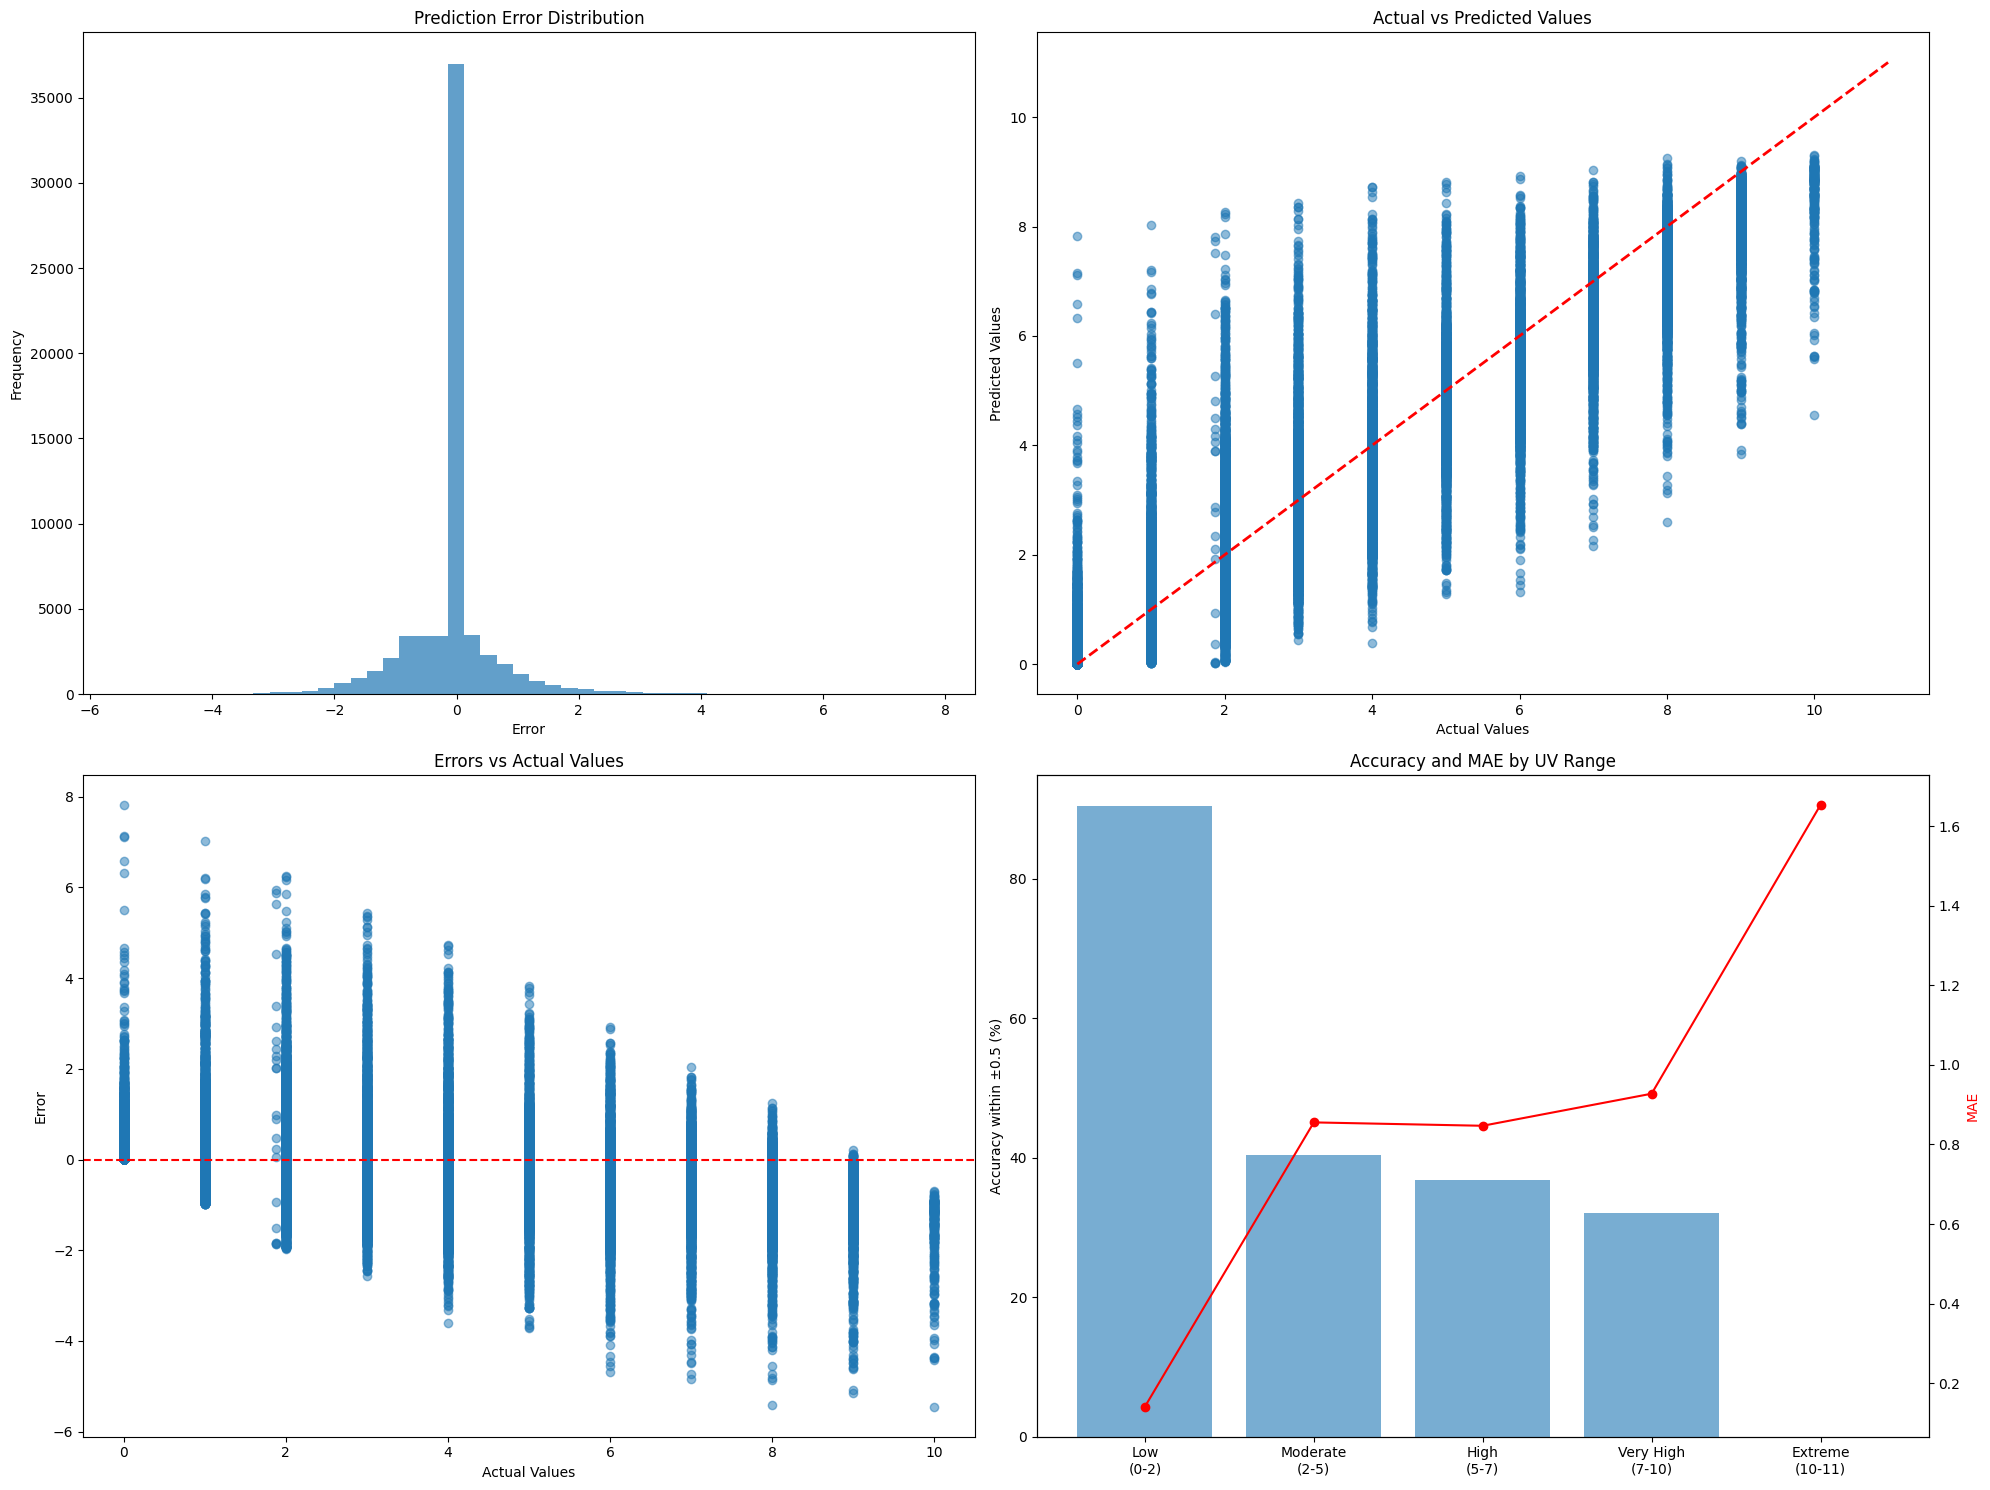

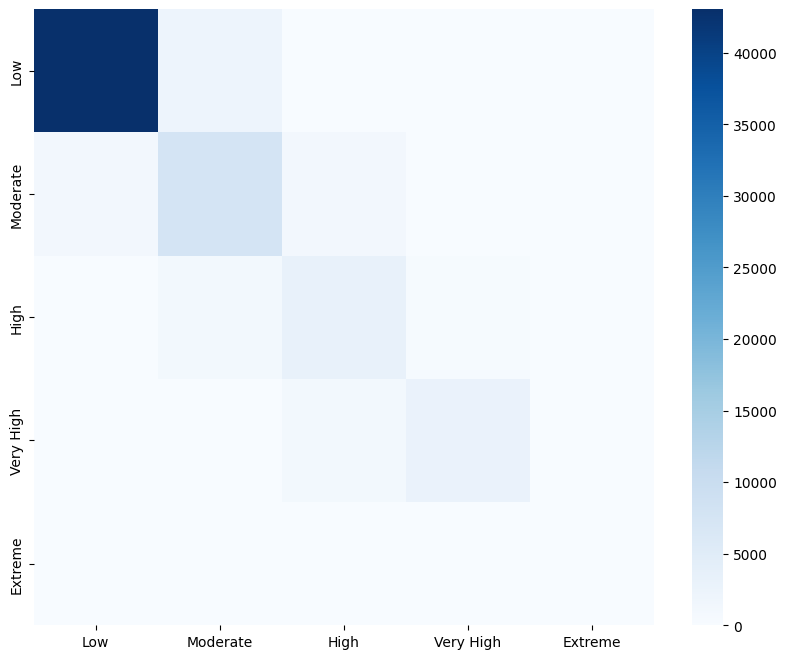

In [11]:
print("\n4. Generating predictions...")
predictions = model.predict(X_test_seq)
predictions = np.clip(predictions, 0, 11)

print("\n5. Model evaluation...")
metrics = evaluate_uv_predictions(y_test, predictions, folder_name=folder_name)

# Save training results only if new training was performed
if not os.path.exists(model_path):
    training_results = {
        'model_params': {
            'input_shape': input_shape,
            'n_features': len(features),
            'sequence_length': X_train_seq.shape[1]
        },
        'training_params': {
            'batch_size': 128,
            'total_epochs': len(history.history['loss']),
            'best_epoch': np.argmin(history.history['val_loss']) + 1,
        },
        'performance_metrics': {
            'final_loss': float(history.history['val_loss'][-1]),
            'final_mae': float(history.history['val_mae'][-1]),
            'best_val_loss': float(min(history.history['val_loss'])),
            'out_of_range_predictions': int(np.sum((predictions < 0) | (predictions > 11)))
        }
    }

    # Save training history
    with open(history_path, 'w') as f:
        history_dict = {key: [float(val) for val in values] 
                      for key, values in history.history.items()}
        json.dump(history_dict, f, indent=4)
else:
    # Load existing training results if available
    results_path = f'{folder_name}_training_results.json'
    if os.path.exists(results_path):
        with open(results_path, 'r') as f:
            training_results = json.load(f)
    else:
        training_results = {}

tf.keras.backend.clear_session()

In [14]:
print("\n6. Predicting missing data...")
to_predict_predictions = model.predict(X_to_predict_seq)
to_predict_predictions = np.clip(to_predict_predictions, 0, 11)

print("\n7. Integrating predictions into dataset...")
df_updated = integrate_predictions(df.copy(), to_predict_predictions)

output_path = f'{folder_name}_weather_data_uvindex.parquet'
df_updated.to_parquet(output_path)
print(f"Updated dataset saved to: {output_path}")

# Add prediction statistics
prediction_stats = {
    'n_predictions_added': len(to_predict_predictions),
    'mean_predicted_uv': float(to_predict_predictions.mean()),
    'min_predicted_uv': float(to_predict_predictions.min()),
    'max_predicted_uv': float(to_predict_predictions.max()),
}

def convert_to_serializable(obj):
    """Convert numpy types to Python standard types for JSON serialization"""
    if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
        np.int16, np.int32, np.int64, np.uint8,
        np.uint16, np.uint32, np.uint64)):
        return int(obj)
    elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    return obj

if not os.path.exists(model_path):
    training_results['prediction_stats'] = prediction_stats

    training_results = convert_to_serializable(training_results)
    # Save final results
    results_path = f'{folder_name}_training_results.json'
    with open(results_path, 'w') as f:
        json.dump(training_results, f, indent=4)

print(f"\nAll files saved with prefix: {folder_name}")


6. Predicting missing data...
7122/7122 [==============================] - 62s 9ms/step

7. Integrating predictions into dataset...
Added 227879 predictions to dataset
Rows with UV index after integration: 357615
Updated dataset saved to: 2024-11-20_11-04_weather_data_uvindex.parquet

All files saved with prefix: 2024-11-20_11-04



Plot saved as: 2024-11-20_11-04/error_analysis.png


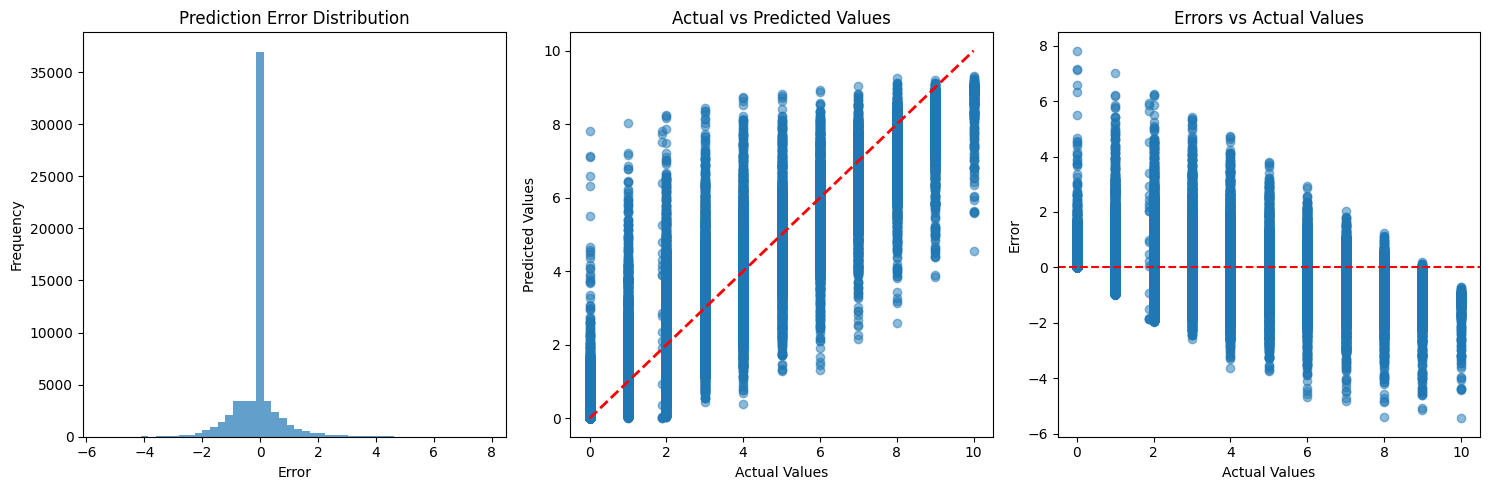


Error statistics:
MAE: 0.4087
MSE: 0.5974
RMSE: 0.7729
Mean errors: -0.0576
Std errors: 0.7707
Predictions within ±0.5: 71.1%
Predictions within ±1.0: 86.0%
Predictions within ±1.5: 93.1%
Predictions within ±2.0: 96.6%


In [15]:
def plot_error_analysis(y_true, y_pred, folder_name=None):
    """
    Function to visualize prediction error analysis

    Parameters:
    -----------
    y_true : array-like
        Actual values
    y_pred : array-like
        Predicted values
    folder_name : str, optional
        Folder to save plots. If None, plots are not saved.
    """
    import os
    from datetime import datetime

    # Convert to 1D numpy array if necessary
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values

    y_true = y_true.ravel()
    y_pred = y_pred.ravel()

    # Calculate errors
    errors = y_pred - y_true

    # Create main figure
    fig = plt.figure(figsize=(15, 5))

    # Plot 1: Error Distribution
    plt.subplot(1, 3, 1)
    plt.hist(errors, bins=50, alpha=0.7)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')

    # Plot 2: Actual vs Predicted
    plt.subplot(1, 3, 2)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Plot 3: Errors vs Actual Values
    plt.subplot(1, 3, 3)
    plt.scatter(y_true, errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Errors vs Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Error')

    plt.tight_layout()

    # Save plot if folder is specified
    if folder_name is not None:
        try:
            # Create folder if it doesn't exist
            os.makedirs(folder_name, exist_ok=True)

            # Generate filename with timestamp
            filename = os.path.join(folder_name, 'error_analysis.png')

            # Save figure
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"\nPlot saved as: {filename}")
        except Exception as e:
            print(f"\nError saving plot: {str(e)}")

    plt.show()

    # Print error statistics
    print("\nError statistics:")
    print(f"MAE: {np.mean(np.abs(errors)):.4f}")
    print(f"MSE: {np.mean(errors ** 2):.4f}")
    print(f"RMSE: {np.sqrt(np.mean(errors ** 2)):.4f}")
    print(f"Mean errors: {np.mean(errors):.4f}")
    print(f"Std errors: {np.std(errors):.4f}")

    # Calculate percentage of errors within thresholds
    thresholds = [0.5, 1.0, 1.5, 2.0]
    for threshold in thresholds:
        within_threshold = np.mean(np.abs(errors) <= threshold) * 100
        print(f"Predictions within ±{threshold}: {within_threshold:.1f}%")


plot_error_analysis(y_test, predictions, folder_name=folder_name)